In [1]:
# IMPORTS
import re
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, Subset
from transformers import AutoTokenizer, AutoModelForCausalLM, PreTrainedModel, TrainingArguments, Trainer

In [2]:
#DIRECTORIES
DATA_PATH = "../input/harry-potter-philosophers-stone-preprocessed/Harry_Potter_philosophers_stone.txt"
SAVED_MODEL_PATH = "../input/harry-potter-text-generator-transformers/checkpoint-25000/trainer_state.json"

In [10]:
#Load the file
text = open(DATA_PATH, "r", encoding="utf-8").read().lower()
sentences = re.split('[.!?]', text)

87.0


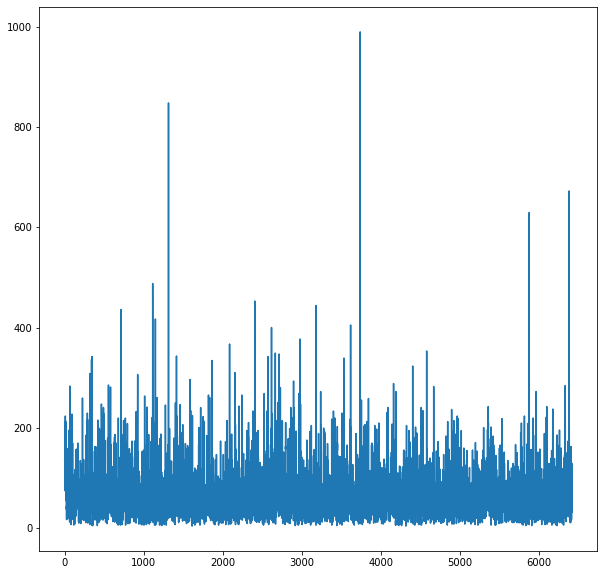

In [43]:
lenghts = [len(sentence) for sentence in sentences]
print(np.percentile(lenghts, 75))

plt.figure(figsize=(10,10))
plt.plot(lenghts)
plt.show()

In [11]:
#Transformers
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained('./weights/checkpoint-25000', local_files_only=True)
#model = AutoModelForCausalLM.from_pretrained("distilgpt2") #weights for fine tuning

In [12]:
tokenizer.pad_token = tokenizer.eos_token
data_token = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=85)

In [13]:
MAX_LENGTH = 85

class Harry_dataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length):
        self.input_ids = []
        self.attn_masks = []
        self.labels = []
        for sentence in sentences:
            encodings_dict = tokenizer('<|startoftext|>' + sentence + '<|endoftext|>', truncation=True,
                                       max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]
    

dataset = Harry_dataset(sentences, tokenizer, max_length=MAX_LENGTH)
train_size = int(0.9 * len(dataset))
train_dataset = Subset(dataset, list(range(0, train_size)))
val_dataset = Subset(dataset, list(range(train_size, len(dataset))))

In [21]:
training_args = TrainingArguments(output_dir='./weights', num_train_epochs=10, logging_steps=5000, logging_strategy='steps', save_strategy='epoch',
                                  per_device_train_batch_size=1, per_device_eval_batch_size=32,
                                  warmup_steps=10, save_total_limit=1, weight_decay=0.05, report_to='none')

PyTorch: setting up devices


In [28]:
Trainer(model=model,  args=training_args, train_dataset=train_dataset, 
        eval_dataset=val_dataset, data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                                              'attention_mask': torch.stack([f[1] for f in data]),
                                                              'labels': torch.stack([f[0] for f in data])}).train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5779
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 57790


Step,Training Loss
5000,0.017000
10000,0.019700
15000,0.020800
20000,0.020300
25000,0.022700
30000,0.045400
35000,0.071500
40000,0.085000
45000,0.101000
50000,0.109500


Saving model checkpoint to ./weights/checkpoint-5779
Configuration saved in ./weights/checkpoint-5779/config.json
Model weights saved in ./weights/checkpoint-5779/pytorch_model.bin
Deleting older checkpoint [weights/checkpoint-57790] due to args.save_total_limit
Saving model checkpoint to ./weights/checkpoint-11558
Configuration saved in ./weights/checkpoint-11558/config.json
Model weights saved in ./weights/checkpoint-11558/pytorch_model.bin
Deleting older checkpoint [weights/checkpoint-5779] due to args.save_total_limit
Saving model checkpoint to ./weights/checkpoint-17337
Configuration saved in ./weights/checkpoint-17337/config.json
Model weights saved in ./weights/checkpoint-17337/pytorch_model.bin
Deleting older checkpoint [weights/checkpoint-11558] due to args.save_total_limit
Saving model checkpoint to ./weights/checkpoint-23116
Configuration saved in ./weights/checkpoint-23116/config.json
Model weights saved in ./weights/checkpoint-23116/pytorch_model.bin
Deleting older checkpo

TrainOutput(global_step=57790, training_loss=0.06076522222500108, metrics={'train_runtime': 2112.0754, 'train_samples_per_second': 27.362, 'train_steps_per_second': 27.362, 'total_flos': 1253446126387200.0, 'train_loss': 0.06076522222500108, 'epoch': 10.0})

In [30]:
begin = 'Harry used to live under starcase but now'
generated = tokenizer.encode(begin, return_tensors='pt').cuda()
attention_mask = torch.ones_like(generated)
sample_outputs = model.generate(generated, do_sample=True, top_k=10, max_new_tokens=200, min_length=100, top_p=0.95, temperature=1.5, no_repeat_ngram_size=3, attention_mask=attention_mask, pad_token_id=tokenizer.eos_token_id)[0]
tokenizer.decode(sample_outputs, skip_special_tokens=True)

'Harry used to live under starcase but now the last boy was going to be walking around school every morning like dad  snapped back vernon with his own wand vernwick  these day vernons would hardly know what had happened ive just know that ive got enough fer a powerful kind of magic to work  wait for dumbledore to get out of the way ive seen so dangerous did dudley  yes  cant say what did you ive no sorts ive found himself suddenly '

In [223]:
#compress folder to zip file
import shutil
shutil.make_archive("GPT2_weights", 'zip', "./checkpoint-25000")

'/kaggle/working/GPT2_weights.zip'